# Neural Networks: CNN

The work of this notebook is based on the paper from Jain et al. [1][2]. A CNN is trained using semantically enriched vectors (using Word2Vec).


[1] Gauri Jain, Manisha Sharma, and Basant Agarwal. Spam detection on social media using semantic convolutional neural network. *International Journal of Knowledge Discovery inBioinformatics (IJKDB)*, 8(1):12–26, 2018.

[2] Gauri Jain, Manisha Sharma, and Basant Agarwal. Spam detection in social media using convolutional and long short term memory neural network. *Annals of Mathematics andArtificial Intelligence*, 85(1):21–44, 2019

## Imports and function definitions

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, Input, LSTM, MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.metrics import accuracy_score, classification_report

In [2]:
def plot_metrics(history, validation=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    # Accuracy
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.plot(history['accuracy'])
    if validation:
        ax1.plot(history['val_accuracy'])
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss') 
    ax2.set_ylabel('Loss') 
    ax2.set_xlabel('Epoch')
    ax2.plot(history['loss'])
    if validation:
        ax2.plot(history['val_loss'])
    ax2.legend(['Train', 'Validation'], loc='upper left') 

    plt.show()

In [3]:
# Show versions
import platform
import keras
import tensorflow as tf

print(f"Python: {platform.python_version()}")
print(f"Keras: {keras.__version__}")
print(f"Tensorflow: {tf.__version__}")

Python: 3.6.9
Keras: 2.4.3
Tensorflow: 2.3.0


In [4]:
# Connect to GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data loading

In [5]:
# When using Goolge Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
base_path = "/content/drive/My Drive"

In [7]:
X_train = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_X_train_en.pkl","rb"))
X_test = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_X_test_en.pkl","rb"))
X_val = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_X_val_en.pkl","rb"))
y_train = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_y_train_en.pkl","rb"))
y_test = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_y_test_en.pkl","rb"))
y_val = pickle.load(open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_y_val_en.pkl","rb"))

In [8]:
print(f"Training set shape {X_train.shape}")
print(f"Validation set shape {X_val.shape}")
print(f"Test set shape {X_test.shape}")

Training set shape (35399, 1528)
Validation set shape (3934, 1528)
Test set shape (16857, 1528)


In [9]:
num_classes = 2  # Number of target classes (Spam and Ham)

In [10]:
print(f"Training labels set size {y_train.shape}")
print(f"Validation labels set size {y_val.shape}")
print(f"Test labels set size {y_test.shape}")

Training labels set size (35399, 2)
Validation labels set size (3934, 2)
Test labels set size (16857, 2)


In [12]:
vocab_size = 150000
max_length = 1528  # 4539 for multilang, 1528 for english only (much shorter cuz stopwords)

## CNN

From the paper of Jain et al. the hyperparameters are:

|   | SMS | Twitter |
|:--|:---:|:-------:|
|Number of filters| 128 | 54 |
|Filter length| 5 | 4 |
|Droput | 0.1 | 0.2 |
|Optimizer | Adagrad (lr: 0.1) | Adagrad (lr: 0.1) |
|Activation function | ReLu | ReLu |
|Epochs | 10 | 10 |

Note that we had to ignore the number of features used by the atuthor to be able to fit the vocabulary in the embedding, accounting for multi-language content (i.e. a bigger number of words). To run one or the other simply change the configuration in the code below.

In [19]:
with tf.device('/device:GPU:0'):
  
  cnn_model = Sequential()

  cnn_model.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length))
  cnn_model.add(Conv1D(filters=54, kernel_size=4, activation="relu"))
  cnn_model.add(MaxPooling1D())
  cnn_model.add(Dropout(rate=0.2))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(units=num_classes, activation="softmax"))

  cnn_model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

  cnn_history = cnn_model.fit(
      X_train,
      y_train,
      epochs=10,
      validation_data=(X_val, y_val)
  )

Epoch 1/10
1107/1107 [==============================] - 29s 27ms/step - loss: 0.4827 - accuracy: 0.7598 - val_loss: 0.4430 - val_accuracy: 0.7694
Epoch 2/10
1107/1107 [==============================] - 29s 26ms/step - loss: 0.4392 - accuracy: 0.7693 - val_loss: 0.4351 - val_accuracy: 0.7725
Epoch 3/10
1107/1107 [==============================] - 29s 26ms/step - loss: 0.4311 - accuracy: 0.7735 - val_loss: 0.4260 - val_accuracy: 0.7883
Epoch 4/10
1107/1107 [==============================] - 29s 26ms/step - loss: 0.4240 - accuracy: 0.7847 - val_loss: 0.4175 - val_accuracy: 0.8055
Epoch 5/10
1107/1107 [==============================] - 29s 26ms/step - loss: 0.4164 - accuracy: 0.7994 - val_loss: 0.4087 - val_accuracy: 0.8071
Epoch 6/10
1107/1107 [==============================] - 30s 27ms/step - loss: 0.4064 - accuracy: 0.8212 - val_loss: 0.3981 - val_accuracy: 0.8638
Epoch 7/10
1107/1107 [==============================] - 29s 26ms/step - loss: 0.3929 - accuracy: 0.8473 - val_loss: 0.3818 -

In [20]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1528, 200)         30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1525, 54)          43254     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 762, 54)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 762, 54)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41148)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82298     
Total params: 30,125,552
Trainable params: 30,125,552
Non-trainable params: 0
__________________________________________

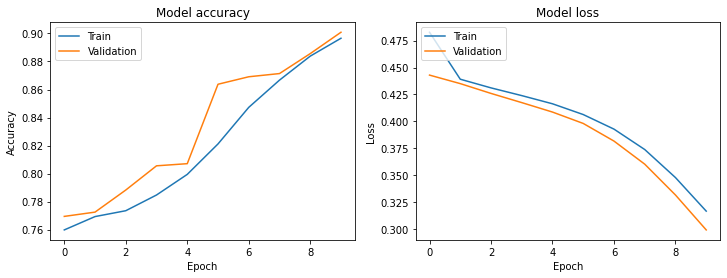

In [21]:
plot_metrics(cnn_history.history, validation=True)

In [22]:
# Save model
cnn_model.save(f"{base_path}/models/2020_11_26_paper_twitter_cnn_en")

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/2020_11_26_paper_twitter_cnn_en/assets


In [23]:
cnn_y_train_predclass = cnn_model.predict(X_train)

sl_cnn_y_train_predclass = np.argmax(cnn_y_train_predclass, axis=1)
sl_y_train = np.argmax(y_train, axis=1)

cnn_train_accuracy = round(accuracy_score(sl_y_train, sl_cnn_y_train_predclass), 3)
print(f"Train accuracy: {cnn_train_accuracy}")

print("Train Classification Report")
print(classification_report(sl_y_train, sl_cnn_y_train_predclass))

Train accuracy: 0.9
Train Classification Report
              precision    recall  f1-score   support

           0       0.87      0.97      0.91     19465
           1       0.95      0.82      0.88     15934

    accuracy                           0.90     35399
   macro avg       0.91      0.89      0.90     35399
weighted avg       0.91      0.90      0.90     35399



In [24]:
cnn_y_test_predclass = cnn_model.predict(X_test)

sl_cnn_y_test_predclass = np.argmax(cnn_y_test_predclass, axis=1)
sl_y_test = np.argmax(y_test, axis=1)

cnn_test_accuracy = round(accuracy_score(sl_y_test, sl_cnn_y_test_predclass), 3)
print(f"Test accuracy: {cnn_test_accuracy}")

print("Test Classification Report")
print (classification_report(sl_y_test, sl_cnn_y_test_predclass))

Test accuracy: 0.903
Test Classification Report
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      9394
           1       0.95      0.82      0.88      7463

    accuracy                           0.90     16857
   macro avg       0.91      0.90      0.90     16857
weighted avg       0.91      0.90      0.90     16857



### Results

Configuration specific to this problem:
- Embedding dimension: 200
- Batch size: 32 (default)
- Vocabulary size: 150000
- Max vector length: 1528

**SMS configuration** (/models/2020_11_26_paper_sms_cnn_en)

- Time per epoch: ~38s
- 10th epoch accuracy: 0.9118
- 10th epoch validation accuracty: 0.9176
- Train set accuracy: 0.917
- Test set accuracy: 0.92

Train set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.89|0.97|0.93|19465|
|1|0.96|0.85|0.90|15934|
||||||
|accuracy|||0.92|35399|
|macro avg|0.92|0.91|0.92|35399|
|weighted avg|0.92|0.92|0.92|35399|

Test set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.90|0.97|0.93|9394|
|1|0.96|0.86|0.90|7463|
||||||
|accuracy|||0.95|16857|
|macro avg|0.95|0.95|0.95|16857|
|weighted avg|0.95|0.95|0.95|16857|


**Twitter configuration** (/models/2020_11_26_paper_twitter_cnn_en)

- Time per epoch: ~38s
- 10th epoch accuracy: 0.9118
- 10th epoch validation accuracty: 0.9176
- Train set accuracy: 0.9
- Test set accuracy: 0.903

Train set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.87|0.97|0.91|19465|
|1|0.95|0.82|0.88|15934|
||||||
|accuracy|||0.90|35399|
|macro avg|0.91|0.89|0.90|35399|
|weighted avg|0.91|0.90|0.90|35399|

Test set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.87|0.97|0.92|9394|
|1|0.95|0.82|0.88|7463|
||||||
|accuracy|||0.90|16857|
|macro avg|0.91|0.90|0.90|16857|
|weighted avg|0.91|0.90|0.90|16857|

## RNN

From the paper of Jain et al. the hyperparameters are:

|   | SMS | Twitter |
|:--|:---:|:-------:|
|Number of units| 100 | 100 |
|Droput | 0.1 | 0.2 |
|Optimizer | Adagrad (lr: 0.1) | Adagrad (lr: 0.1) |
|Activation function | ReLu | ReLu |
|Epochs | 10 | 10 |

Note that we had to ignore the number of features used by the atuthor to be able to fit the vocabulary in the embedding, accounting for multi-language content (i.e. a bigger number of words). To run one or the other simply change the configuration in the code below.



In [31]:
with tf.device('/device:GPU:0'):
  
  rnn_model = Sequential()

  rnn_model.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length))
  rnn_model.add(LSTM(units=100))
  rnn_model.add(Dropout(rate=0.2))
  rnn_model.add(Dense(units=num_classes, activation="sigmoid"))

  rnn_model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

  rnn_history = rnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
1107/1107 [==============================] - 85s 77ms/step - loss: 0.6883 - accuracy: 0.5492 - val_loss: 0.6849 - val_accuracy: 0.5488
Epoch 2/10
1107/1107 [==============================] - 85s 77ms/step - loss: 0.6816 - accuracy: 0.5499 - val_loss: 0.6785 - val_accuracy: 0.5488
Epoch 3/10
1107/1107 [==============================] - 85s 77ms/step - loss: 0.6735 - accuracy: 0.5499 - val_loss: 0.6675 - val_accuracy: 0.5488
Epoch 4/10
1107/1107 [==============================] - 85s 77ms/step - loss: 0.6393 - accuracy: 0.5894 - val_loss: 0.5254 - val_accuracy: 0.7758
Epoch 5/10
1107/1107 [==============================] - 86s 77ms/step - loss: 0.4678 - accuracy: 0.7818 - val_loss: 0.4420 - val_accuracy: 0.7888
Epoch 6/10
1107/1107 [==============================] - 85s 77ms/step - loss: 0.4075 - accuracy: 0.8152 - val_loss: 0.3766 - val_accuracy: 0.8378
Epoch 7/10
1107/1107 [==============================] - 85s 77ms/step - loss: 0.3452 - accuracy: 0.8612 - val_loss: 0.8116 -

In [32]:
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1528, 200)         30000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 30,120,602
Trainable params: 30,120,602
Non-trainable params: 0
_________________________________________________________________


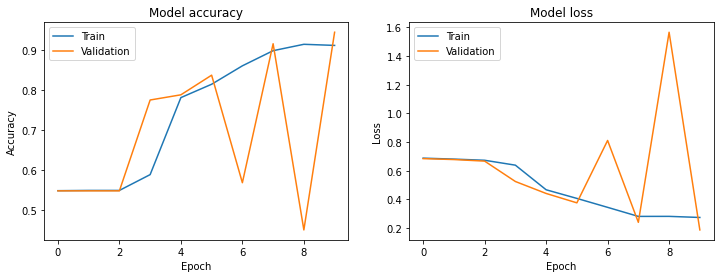

In [33]:
plot_metrics(rnn_history.history, validation=True)

In [34]:
rnn_model.save(f"{base_path}/models/2020_11_26_paper_twitter_rnn_en")

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/2020_11_26_paper_twitter_rnn_en/assets


In [35]:
rnn_y_train_predclass = rnn_model.predict(X_train)

sl_rnn_y_train_predclass = np.argmax(rnn_y_train_predclass, axis=1)
sl_y_train = np.argmax(y_train, axis=1)

rnn_train_accuracy = round(accuracy_score(sl_y_train, sl_rnn_y_train_predclass), 3)
print(f"Train accuracy: {rnn_train_accuracy}")

print("Train Classification Report")
print(classification_report(sl_y_train, sl_rnn_y_train_predclass))

Train accuracy: 0.946
Train Classification Report
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     19465
           1       0.99      0.89      0.94     15934

    accuracy                           0.95     35399
   macro avg       0.95      0.94      0.95     35399
weighted avg       0.95      0.95      0.95     35399



In [36]:
rnn_y_test_predclass = rnn_model.predict(X_test)

sl_rnn_y_test_predclass = np.argmax(rnn_y_test_predclass, axis=1)
sl_y_test = np.argmax(y_test, axis=1)

rnn_test_accuracy = round(accuracy_score(sl_y_test, sl_rnn_y_test_predclass), 3)
print(f"Test accuracy: {rnn_test_accuracy}")

print("Test Classification Report")
print (classification_report(sl_y_test, sl_rnn_y_test_predclass))

Test accuracy: 0.946
Test Classification Report
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9394
           1       0.99      0.89      0.94      7463

    accuracy                           0.95     16857
   macro avg       0.95      0.94      0.94     16857
weighted avg       0.95      0.95      0.95     16857



### Results

Configuration specific to this problem:
- Embedding dimension: 200
- Batch size: 32 (default)
- Vocabulary size: 150000
- Max vector length: 1528

**SMS configuration** (/models/2020_11_26_paper_sms_rnn_en)

- Time per epoch: ~85s
- 10th epoch accuracy: 0.9463
- 10th epoch validation accuracty: 0.9504
- Train set accuracy: 0.948
- Test set accuracy: 0.949

Train set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.92|0.99|0.95|19465|
|1|0.99|0.89|0.94|15394|
||||||
|accuracy|||0.95|35399|
|macro avg|0.95|0.94|0.95|35399|
|weighted avg|0.95|0.95|0.95|35399|

Test set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.92|0.99|0.96|9394|
|1|0.99|0.90|0.94|7463|
||||||
|accuracy|||0.95|16857|
|macro avg|0.96|0.94|0.95|16857|
|weighted avg|0.95|0.95|0.95|16857|


**Twitter configuration** (/models/2020_11_26_paper_twitter_rnn_en)

- Time per epoch: ~85s
- 10th epoch accuracy: 0.9122
- 10th epoch validation accuracty: 0.9451
- Train set accuracy: 0.946
- Test set accuracy: 0.946

Train set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.92|0.99|0.95|19465|
|1|0.99|0.89|0.94|15394|
||||||
|accuracy|||0.95|35399|
|macro avg|0.95|0.94|0.95|35399|
|weighted avg|0.95|0.95|0.95|35399|

Test set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.92|0.99|0.95|9394|
|1|0.99|0.89|0.94|7463|
||||||
|accuracy|||0.95|16857|
|macro avg|0.96|0.94|0.94|16857|
|weighted avg|0.95|0.95|0.95|16857|

## CNN + RNN


From the paper of Jain et al. the hyperparameters are:

|   | SMS | Twitter |
|:--|:---:|:-------:|
|Number of filters| 128 | 54 |
|Number of units| 100 | 100 |
|Filter length| 5 | 4 |
|Droput | 0.1 | 0.2 |
|Optimizer | Adagrad (lr: 0.1) | Adagrad (lr: 0.1) |
|Activation function | ReLu | ReLu |
|Epochs | 10 | 10 |

Note that we had to ignore the number of features used by the atuthor to be able to fit the vocabulary in the embedding, accounting for multi-language content (i.e. a bigger number of words). To run one or the other simply change the configuration in the code below.

In [43]:
with tf.device('/device:GPU:0'):
  
  crnn_model = Sequential()

  crnn_model.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length))
  crnn_model.add(Conv1D(filters=54, kernel_size=4, activation="relu"))
  crnn_model.add(MaxPooling1D())
  crnn_model.add(LSTM(units=100))
  crnn_model.add(Dropout(rate=0.2))
  crnn_model.add(Flatten())
  crnn_model.add(Dense(units=num_classes, activation="softmax"))

  crnn_model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

  crnn_history = crnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
1107/1107 [==============================] - 63s 57ms/step - loss: 0.6735 - accuracy: 0.5499 - val_loss: 0.6462 - val_accuracy: 0.5488
Epoch 2/10
1107/1107 [==============================] - 61s 55ms/step - loss: 0.5303 - accuracy: 0.7154 - val_loss: 0.4607 - val_accuracy: 0.7745
Epoch 3/10
1107/1107 [==============================] - 60s 55ms/step - loss: 0.4432 - accuracy: 0.7792 - val_loss: 0.4280 - val_accuracy: 0.7855
Epoch 4/10
1107/1107 [==============================] - 61s 55ms/step - loss: 0.4090 - accuracy: 0.8025 - val_loss: 0.3881 - val_accuracy: 0.8205
Epoch 5/10
1107/1107 [==============================] - 60s 55ms/step - loss: 0.3552 - accuracy: 0.8595 - val_loss: 0.3164 - val_accuracy: 0.8907
Epoch 6/10
1107/1107 [==============================] - 60s 54ms/step - loss: 0.2613 - accuracy: 0.9160 - val_loss: 0.2074 - val_accuracy: 0.9319
Epoch 7/10
1107/1107 [==============================] - 60s 54ms/step - loss: 0.1865 - accuracy: 0.9417 - val_loss: 0.1664 -

In [38]:
crnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1528, 200)         30000000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1524, 128)         128128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 762, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

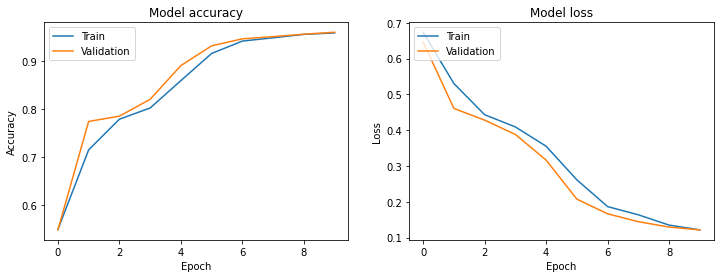

In [44]:
plot_metrics(crnn_history.history, validation=True)

In [45]:
crnn_model.save(f"{base_path}/models/2020_11_26_paper_twitter_crnn_en")

INFO:tensorflow:Assets written to: /content/drive/My Drive/models/2020_11_26_paper_twitter_crnn_en/assets


In [46]:
crnn_y_train_predclass = crnn_model.predict(X_train)

sl_crnn_y_train_predclass = np.argmax(crnn_y_train_predclass, axis=1)
sl_y_train = np.argmax(y_train, axis=1)

crnn_train_accuracy = round(accuracy_score(sl_y_train, sl_crnn_y_train_predclass), 3)
print(f"Train accuracy: {crnn_train_accuracy}")

print("Train Classification Report")
print(classification_report(sl_y_train, sl_crnn_y_train_predclass))

Train accuracy: 0.962
Train Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     19465
           1       0.99      0.93      0.96     15934

    accuracy                           0.96     35399
   macro avg       0.97      0.96      0.96     35399
weighted avg       0.96      0.96      0.96     35399



In [47]:
crnn_y_test_predclass = crnn_model.predict(X_test)

sl_crnn_y_test_predclass = np.argmax(crnn_y_test_predclass, axis=1)
sl_y_test = np.argmax(y_test, axis=1)

crnn_test_accuracy = round(accuracy_score(sl_y_test, sl_crnn_y_test_predclass), 3)
print(f"Test accuracy: {crnn_test_accuracy}")

print("Test Classification Report")
print (classification_report(sl_y_test, sl_crnn_y_test_predclass))

Test accuracy: 0.963
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9394
           1       0.99      0.93      0.96      7463

    accuracy                           0.96     16857
   macro avg       0.97      0.96      0.96     16857
weighted avg       0.96      0.96      0.96     16857



### Results

Configuration specific to this problem:
- Embedding dimension: 200
- Batch size: 32 (default)
- Vocabulary size: 150000
- Max vector length: 4539

**SMS configuration** (/models/2020_11_26_paper_sms_crnn_en)

- Time per epoch: ~69s
- 10th epoch accuracy: 0.9644
- 10th epoch validation accuracy: 0.9626
- Train set accuracy: 0.965
- Test set accuracy: 0.965

Train set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.94|0.99|0.97|19465|
|1|0.99|0.93|0.96|15934|
||||||
|accuracy|||0.96|35399|
|macro avg|0.97|0.96|0.96|35399|
|weighted avg|0.97|0.96|0.96|35399|

Test set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.95|0.99|0.97|9394|
|1|0.99|0.93|0.96|7463|
||||||
|accuracy|||0.96|16857|
|macro avg|0.97|0.96|0.96|16857|
|weighted avg|0.97|0.96|0.96|16857|


**Twitter configuration** (/models/2020_11_26_paper_crnn_twitter_en)

- Time per epoch: ~69s
- 10th epoch accuracy: 0.9644
- 10th epoch validation accuracy: 0.9626
- Train set accuracy: 0.962
- Test set accuracy: 0.963

Train set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.94|0.99|0.97|19465|
|1|0.99|0.93|0.96|15934|
||||||
|accuracy|||0.96|35399|
|macro avg|0.97|0.96|0.96|35399|
|weighted avg|0.96|0.96|0.96|35399|


Test set report:

|  |Precission|Recall|F1 Score|Support|
|:-|:-:|:-:|:-:|:-:|
|0|0.95|0.99|0.97|9394|
|1|0.99|0.93|0.96|7463|
||||||
|accuracy|||0.96|16857|
|macro avg|0.97|0.96|0.96|16857|
|weighted avg|0.96|0.96|0.96|16857|